In [1]:
import os as os
import glob as glob

import numpy as np
import pandas as pd

import theano
import theano.tensor as theanoTensor

from scipy.stats import zscore

import matplotlib.pyplot as plt

os.chdir('/Users/mcmenamin/GitHub/theanoStocks')
import theanoRegr
import theanoLstm

In [2]:
# read in text data for all daily stock reports
fileList = glob.glob('./quantquote_daily_sp500_83986/daily/table_*.csv')
allFrames = []
stockNames = []
for f in fileList:
    stockNames.append(f.split('_')[-1][:-4])
    #print(stockNames[-1])
    colNames = ['date', 'time', 'open', 'high', 'low', 'close', 'volume']
    allFrames.append(pd.read_csv(f, sep=',', names=colNames))
allStocks = pd.concat(allFrames, keys=stockNames)
allFrames = None

In [4]:
# restrict to stocks that exist the whole time
goodStocks = [s for s in stockNames if len(allStocks.ix[s]) == 3926]

# make timeseries using open/close prices for the 'good' stocks
fullTimeseries = []
for s in goodStocks:
    tmp = allStocks.ix[s][['open', 'close']].values.ravel()
    fullTimeseries.append(np.array(tmp))
fullTimeseries = np.vstack(fullTimeseries)
fullTimeseries = zscore(fullTimeseries, axis=1)

trainTimeseries = fullTimeseries[:, :(fullTimeseries.shape[1] // 2)]
testTimeseries = fullTimeseries[:, (fullTimeseries.shape[1] // 2):]

In [5]:
trainTimeseries.shape

(388, 3926)

In [6]:
numLags = 14 * 2  # lag for the last ~2 weeks
stockIdx = 200

trainY = trainTimeseries[stockIdx, numLags:]
testY = testTimeseries[stockIdx, numLags:]
trainX = []
testX = []
for i in range(1, numLags):
    trainX.append(trainTimeseries[stockIdx, (numLags - i):-i])
    testX.append(testTimeseries[stockIdx, (numLags - i):-i])
trainX = np.vstack(trainX).T
testX = np.vstack(testX).T
n_in = trainX.shape[1]

In [8]:
####################################################
####################################################
#
# Building simple linear regression in Theano
#

testLinear = False
if testLinear:
    model = theanoRegr.LinearRegression(n_in)
    model.fit(trainX, trainY)

    plt.plot(model.W.get_value())
    model.fit(trainX, trainY)

    print(model.test_model(trainX, trainY))
    print(model.test_model(testX, testY))

In [9]:
####################################################
####################################################
#
# Building LSTM model using Keras to control Theano
#

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD

numStocks = 1
numHidden = 30
numLags = n_in

model = Sequential()
model.add(LSTM(numHidden,
               return_sequences=False,
               input_shape=(numLags, numStocks)
               ))
model.add(Dense(numStocks))
model.add(Activation('linear'))


sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

trainX2 = trainX.reshape(trainX.shape[0], n_in, 1)
testX2 = testX.reshape(testX.shape[0], n_in, 1)
model.fit(trainX2,
          trainY,
          nb_epoch=150,
          batch_size=25,
          verbose=0)
score = model.evaluate(testX2, testY, batch_size=25)
print(score)

Using Theano backend.


3898/3898 [==============================] - 0s     
0.0028906152911


In [10]:
predY = model.predict(testX2)

<IPython.core.display.Javascript object>


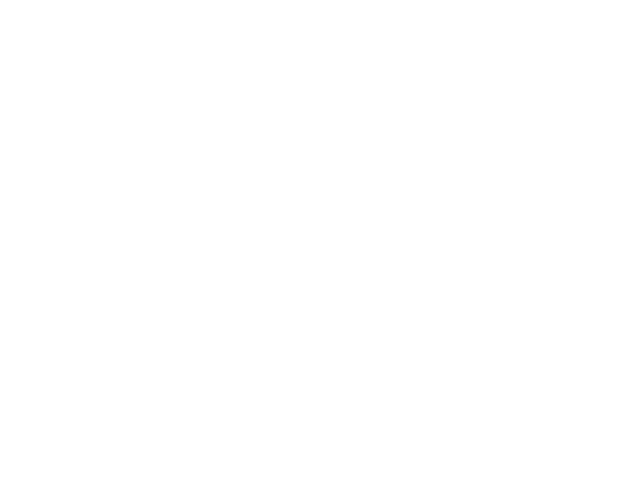

In [11]:
%matplotlib nbagg
plt.figure()
plt.plot(testY, '-k')
plt.plot(predY, '--k')

In [12]:
testX2

array([[[ 0.45181515],
        [ 0.43079789],
        [ 0.42253795],
        ..., 
        [ 0.34746367],
        [ 0.32644641],
        [ 0.30918287]],

       [[ 0.47212415],
        [ 0.45181515],
        [ 0.43079789],
        ..., 
        [ 0.33320133],
        [ 0.34746367],
        [ 0.32644641]],

       [[ 0.50899731],
        [ 0.47212415],
        [ 0.45181515],
        ..., 
        [ 0.36473607],
        [ 0.33320133],
        [ 0.34746367]],

       ..., 
       [[ 1.90810562],
        [ 1.88951411],
        [ 1.88951411],
        ..., 
        [ 2.07454388],
        [ 2.05329644],
        [ 2.08782353]],

       [[ 1.89217004],
        [ 1.90810562],
        [ 1.88951411],
        ..., 
        [ 2.03470493],
        [ 2.07454388],
        [ 2.05329644]],

       [[ 1.8700373 ],
        [ 1.89217004],
        [ 1.90810562],
        ..., 
        [ 2.0586083 ],
        [ 2.03470493],
        [ 2.07454388]]])

In [13]:
trainX2 = trainX.reshape(trainX.shape[0], n_in, 1)
testX2 = testX.reshape(testX.shape[0], n_in, 1)

In [14]:
predY = np.zeros(testY.shape)
currentWindow = np.copy(testX2[1:2,:,:])
for i in range(1,len(predY)):
    predY[i] = model.predict(currentWindow)
    currentWindow = np.hstack([currentWindow.ravel()[1:],predY[i]]).reshape(1,-1,1)

<IPython.core.display.Javascript object>


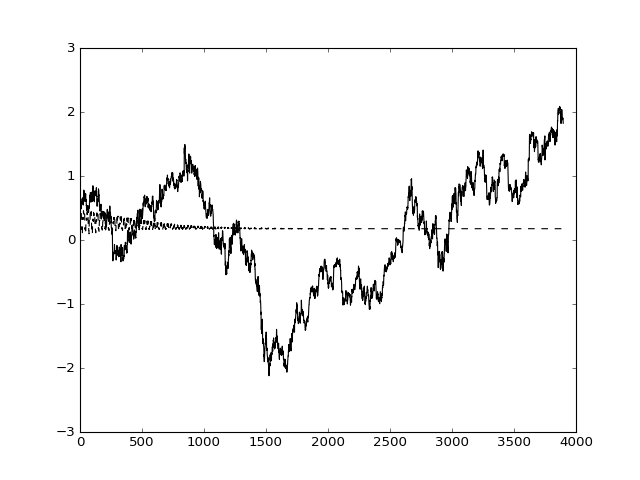

In [15]:
%matplotlib nbagg
plt.figure()
plt.plot(testY, '-k')
plt.plot(predY, '--k')